In [1]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn as sns
from sklearn.decomposition import PCA
import random
import scipy

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [5]:
latent_df = pd.read_csv("level5Latent.csv").drop("Unnamed: 0", axis = 1)
pca = PCA(n_components=latent_dim)
pca_latent_df = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)

In [6]:
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)
meta_moa_pca_latent_df = pd.concat([complete_meta_df,moa_df,pca_latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,complete_features_df], axis=1)

# fill negative control DMSO profiles, change the NaN MOA label to be DMSO
meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_pca_latent_df.loc[meta_moa_pca_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'
meta_moa_complete_df.loc[meta_moa_complete_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

#drop profiles with NaN MOAs
meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_pca_latent_df = meta_moa_pca_latent_df.dropna(subset=['moa']).reset_index(drop = True)
meta_moa_complete_df = meta_moa_complete_df.dropna(subset=['moa']).reset_index(drop = True)

# add columns to the dataframe that are randomnly shuffled permutations of the MOA column
for i in range(NUM_RANDOM_SAMPLES):
    random_moa_labels = pd.DataFrame([meta_moa_latent_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
    random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})

    meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
    meta_moa_pca_latent_df = pd.concat([random_moa_labels, meta_moa_pca_latent_df], axis=1)

    meta_moa_complete_df = pd.concat([random_moa_labels, meta_moa_complete_df], axis=1)

meta_moa_complete_df.head()

,random_moa_labels9,random_moa_labels8,random_moa_labels7,random_moa_labels6,random_moa_labels5,random_moa_labels4,random_moa_labels3,random_moa_labels2,random_moa_labels1,random_moa_labels0,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,retinoid receptor agonist,transthyretin amyloid inhibitor,androgen receptor antagonist,serotonin receptor antagonist,retinoid receptor agonist,DMSO,androgen receptor modulator,proteasome inhibitor,adrenergic receptor antagonist,SYK inhibitor,...,0.164260,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,phosphodiesterase inhibitor,topoisomerase inhibitor,calcium channel blocker,beta lactamase inhibitor,mTOR inhibitor|PI3K inhibitor,FGFR inhibitor|VEGFR inhibitor,NFkB pathway inhibitor|proteasome inhibitor,NFkB pathway inhibitor|proteasome inhibitor,topoisomerase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,...,0.184110,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,glucokinase inhibitor,NFkB pathway inhibitor|proteasome inhibitor,histamine receptor antagonist,VEGFR inhibitor,DMSO,adrenergic receptor antagonist,Pim kinase inhibitor,kainate receptor antagonist,ATP channel activator|potassium channel activator,uricosuric blocker,...,0.175640,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086
3,leukotriene synthesis inhibitor|lipoxygenase i...,prostacyclin analog,nucleoside reverse transcriptase inhibitor,platelet aggregation inhibitor,WEE1 kinase inhibitor,DMSO,DMSO,dehydrogenase inhibitor,cyclooxygenase inhibitor,mTOR inhibitor|PI3K inhibitor,...,0.141310,0.18764,0.17342,0.18641,0.54696,0.44890,0.40042,0.30187,0.35082,0.32103
4,leukotriene receptor antagonist,opioid receptor agonist|opioid receptor antago...,protein synthesis inhibitor,DMSO,prostanoid receptor antagonist,carboxamide antiepileptic,PLK inhibitor,DNA inhibitor,phosphodiesterase inhibitor,adrenergic receptor antagonist,...,0.094635,0.16631,0.15218,0.15540,0.56882,0.46601,0.40149,0.31658,0.36167,0.33338


In [7]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [8]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [9]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
subset_pca_means = []
subset_pca_random_means = []
subset_complete_means = []
subset_complete_random_means = []

for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_mean = subset.groupby(['moa'])[latent_space_columns].mean()
    subset_pca = subset_by_moa(pipe, meta_moa_pca_latent_df, 'moa')
    subset_pca_mean = subset_pca.groupby(['moa'])[latent_space_columns].mean()
    subset_complete = subset_by_moa(pipe, meta_moa_complete_df, 'moa')
    subset_complete_mean = subset_complete.groupby(['moa'])[complete_features_df.columns].mean()
    
    
    subsets_random_mean = []
    subsets_pca_random_mean = []
    subsets_complete_random_mean = []
    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        subset_random = subset_by_moa(pipe, meta_moa_latent_df, label)
        subset_random_mean = subset_random.groupby([label])[latent_space_columns].mean()
        subsets_random_mean.append(subset_random_mean)
        
        subset_pca_random = subset_by_moa(pipe, meta_moa_pca_latent_df, label)
        subset_pca_random_mean = subset_pca_random.groupby([label])[latent_space_columns].mean()
        subsets_pca_random_mean.append(subset_pca_random_mean)
        
        subset_complete_random = subset_by_moa(pipe, meta_moa_complete_df, label)
        subset_complete_random_mean = subset_complete_random.groupby([label])[complete_features_df.columns].mean()
        subsets_complete_random_mean.append(subset_complete_random_mean)
    
    subset_means.append(subset_mean)
    subset_pca_means.append(subset_pca_mean)
    subset_complete_means.append(subset_complete_mean)
    
    subset_random_means.append(subsets_random_mean)
    subset_pca_random_means.append(subsets_pca_random_mean)
    subset_complete_random_means.append(subsets_complete_random_mean)



In [10]:
#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
DMSO_pca = meta_moa_pca_latent_df[meta_moa_pca_latent_df.moa == 'DMSO']
DMSO_complete = meta_moa_complete_df[meta_moa_complete_df.moa == 'DMSO']

DMSO_means = np.mean(DMSO[latent_space_columns])
DMSO_means_pca = np.mean(DMSO_pca[latent_space_columns])
DMSO_means_complete = np.mean(DMSO_complete[complete_features_df.columns])


DMSO_means_random = []
DMSO_means_pca_random = []
DMSO_means_complete_random = []

for i in range(NUM_RANDOM_SAMPLES):
    label = 'random_moa_labels' + str(i)
    DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
    DMSO_means_random.append(np.mean(DMSO_random[latent_space_columns]))

    DMSO_pca_random = meta_moa_pca_latent_df[meta_moa_pca_latent_df[label] == 'DMSO']
    DMSO_means_pca_random.append(np.mean(DMSO_pca_random[latent_space_columns]))
    
    DMSO_complete_random = meta_moa_complete_df[meta_moa_complete_df[label] == 'DMSO']
    DMSO_means_complete_random.append(np.mean(DMSO_complete_random[complete_features_df.columns]))

In [11]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
representations_after_LSA_pca = []
representations_after_LSA_pca_random = []
representations_after_LSA_complete = []
representations_after_LSA_complete_random = []


for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    
    representation_after_LSA_pca = LSA(subset_pca_means[i].loc[valid_pipes[i].split("|")[0]],subset_pca_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca)
    representation_after_LSA_pca = pd.DataFrame(representation_after_LSA_pca).transpose()
    representations_after_LSA_pca.append(representation_after_LSA_pca)
    
    representation_after_LSA_complete = LSA(subset_complete_means[i].loc[valid_pipes[i].split("|")[0]],subset_complete_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete)
    representation_after_LSA_complete = pd.DataFrame(representation_after_LSA_complete).transpose()
    representations_after_LSA_complete.append(representation_after_LSA_complete)
    
    
    LSA_random_1pipe = []
    PCA_random_1pipe = []
    complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
        representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
        LSA_random_1pipe.append(representation_after_LSA_random)    

        representation_after_LSA_pca_random = LSA(subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_pca_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_pca_random[j])
        representation_after_LSA_pca_random = pd.DataFrame(representation_after_LSA_pca_random).transpose()
        PCA_random_1pipe.append(representation_after_LSA_pca_random)
        
        representation_after_LSA_complete_random = LSA(subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_complete_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_complete_random[j])
        representation_after_LSA_complete_random = pd.DataFrame(representation_after_LSA_complete_random).transpose()
        complete_random_1pipe.append(representation_after_LSA_complete_random)
        
    representations_after_LSA_random.append(LSA_random_1pipe)
    representations_after_LSA_pca_random.append(PCA_random_1pipe)
    representations_after_LSA_complete_random.append(complete_random_1pipe)


In [12]:
decoder = keras.models.load_model("../2.train/level5Decoder")


In [13]:
#decode each latent space representation

predictions = []
predictions_random = []
predictions_pca = []
predictions_pca_random = []
predictions_complete = []
predictions_complete_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_pca.append(pca.inverse_transform(representations_after_LSA_pca[i]))
    predictions_complete.append(representations_after_LSA_complete[i].values.tolist())
    
    predictions_random_1pipe = []
    predictions_pca_random_1pipe = []
    predictions_complete_random_1pipe = []
    for j in range(NUM_RANDOM_SAMPLES):
        predictions_random_1pipe.append(decoder.predict(representations_after_LSA_random[i][j]))
        predictions_pca_random_1pipe.append(pca.inverse_transform(representations_after_LSA_pca_random[i][j]))
        predictions_complete_random_1pipe.append(representations_after_LSA_complete_random[i][j].values.tolist())

    predictions_random.append(predictions_random_1pipe)
    predictions_pca_random.append(predictions_pca_random_1pipe)
    predictions_complete_random.append(predictions_complete_random_1pipe)
        
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)
predictions_pca = np.array(predictions_pca)
predictions_pca_random = np.array(predictions_pca_random)
predictions_complete = np.array(predictions_complete)
predictions_complete_random = np.array(predictions_complete_random)

In [14]:
# meta_moa_complete_df.columns.to_list()

In [15]:
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
# mean_of_moas = mean_of_moas[mean_of_moas.index.str.contains('\|')]

In [16]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
L2 = []
L2_random = []
L2_pca = []
L2_pca_random = []
L2_complete = []
L2_complete_random = []
moa_similarity = []

per_moa_zscore_vae = []
per_moa_zscore_pca = []
per_moa_zscore_complete = []


mean = complete_features_df.mean()

for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    similarity = np.linalg.norm(desired_moa[0] - mean)

    single_L2 = np.linalg.norm(predictions[i][0]-desired_moa[0])
    single_L2_pca = np.linalg.norm(predictions_pca[i][0]-desired_moa[0])
    single_L2_complete = np.linalg.norm(predictions_complete[i][0]-desired_moa[0])

    L2.append(single_L2)
    L2_pca.append(single_L2_pca)
    L2_complete.append(single_L2_complete)

    L2_random_per_moa = []
    L2_pca_random_per_moa = []
    L2_complete_random_per_moa = []
    for j in range(NUM_RANDOM_SAMPLES):
        L2_random_per_moa.append(np.linalg.norm(predictions_random[i][j][0]-desired_moa[0]))
        L2_pca_random_per_moa.append(np.linalg.norm(predictions_pca_random[i][j][0]-desired_moa[0]))
        L2_complete_random_per_moa.append(np.linalg.norm(predictions_complete_random[i][j][0]-desired_moa[0]))

    L2_random += L2_random_per_moa
    L2_pca_random += L2_pca_random_per_moa
    L2_complete_random += L2_complete_random_per_moa

    zscore_vae = scipy.stats.zscore(L2_random_per_moa + [single_L2])[-1]
    zscore_pca = scipy.stats.zscore(L2_pca_random_per_moa + [single_L2_pca])[-1]
    zscore_complete = scipy.stats.zscore(L2_complete_random_per_moa + [single_L2_complete])[-1]

    per_moa_zscore_vae.append(zscore_vae)
    per_moa_zscore_pca.append(zscore_pca)
    per_moa_zscore_complete.append(zscore_complete)
    moa_similarity.append(similarity)


In [17]:
# per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae pvalue":per_moa_pvalues_vae,"vae tstat":per_moa_tstat_vae,"pca pvalue":per_moa_pvalues_pca,"pca tstat":per_moa_tstat_pca, "moa similarity":moa_similarity})
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae zscore":per_moa_zscore_vae,"pca zscore":per_moa_zscore_pca, "moa similarity":moa_similarity})

per_moa_performance_df.to_csv('ttest_per_moa.tsv', sep = '\t')


In [18]:
per_moa_performance_df

,MOA,vae zscore,pca zscore,moa similarity
0,NFkB pathway inhibitor|proteasome inhibitor,-3.152561,-2.860136,5.111749
1,dopamine receptor antagonist|serotonin recepto...,0.700629,-0.926472,0.507123
2,cyclooxygenase inhibitor|prostanoid receptor a...,1.271352,-0.280941,0.515390
3,mTOR inhibitor|PI3K inhibitor,-3.110497,-2.873185,2.238932
4,insulin sensitizer|PPAR receptor agonist,-0.379198,-0.244728,0.609560
...,...,...,...,...
79,SRC inhibitor|tubulin polymerization inhibitor,-3.045737,-2.816254,4.022180
80,adrenergic receptor agonist|imidazoline recept...,-0.134483,0.340120,0.816092
81,SRC inhibitor|VEGFR inhibitor,-0.016884,1.670780,1.384400
82,acetylcholinesterase inhibitor|monoamine oxida...,-1.454282,-1.441912,1.560094


In [19]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae zscore')
per_moa_performance_df.to_csv('level5_beta_moa_performance.csv')

In [20]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae zscore'] < 0]
well_predicted.to_csv('well_predicted_level5.csv')
well_predicted

,MOA,vae zscore,pca zscore,moa similarity
0,NFkB pathway inhibitor|proteasome inhibitor,-3.152561,-2.860136,5.111749
17,microtubule inhibitor|tubulin polymerization i...,-3.144751,-2.908896,5.388521
3,mTOR inhibitor|PI3K inhibitor,-3.110497,-2.873185,2.238932
58,Aurora kinase inhibitor|JAK inhibitor,-3.100413,-2.836145,5.080567
46,DNA inhibitor|topoisomerase inhibitor,-3.090222,-2.892930,3.116495
79,SRC inhibitor|tubulin polymerization inhibitor,-3.045737,-2.816254,4.022180
60,EGFR inhibitor|VEGFR inhibitor,-2.927428,2.010866,1.212173
18,DNA alkylating agent|DNA synthesis inhibitor,-2.650289,-2.199296,3.704015
51,glucocorticoid receptor agonist|immunosuppressant,-2.612471,-2.717692,2.007021
56,RNA synthesis inhibitor|topoisomerase inhibitor,-2.411932,-1.596294,3.580546


In [26]:
sns.set_theme()

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'A|B distance to mean Cell Painting feature values')

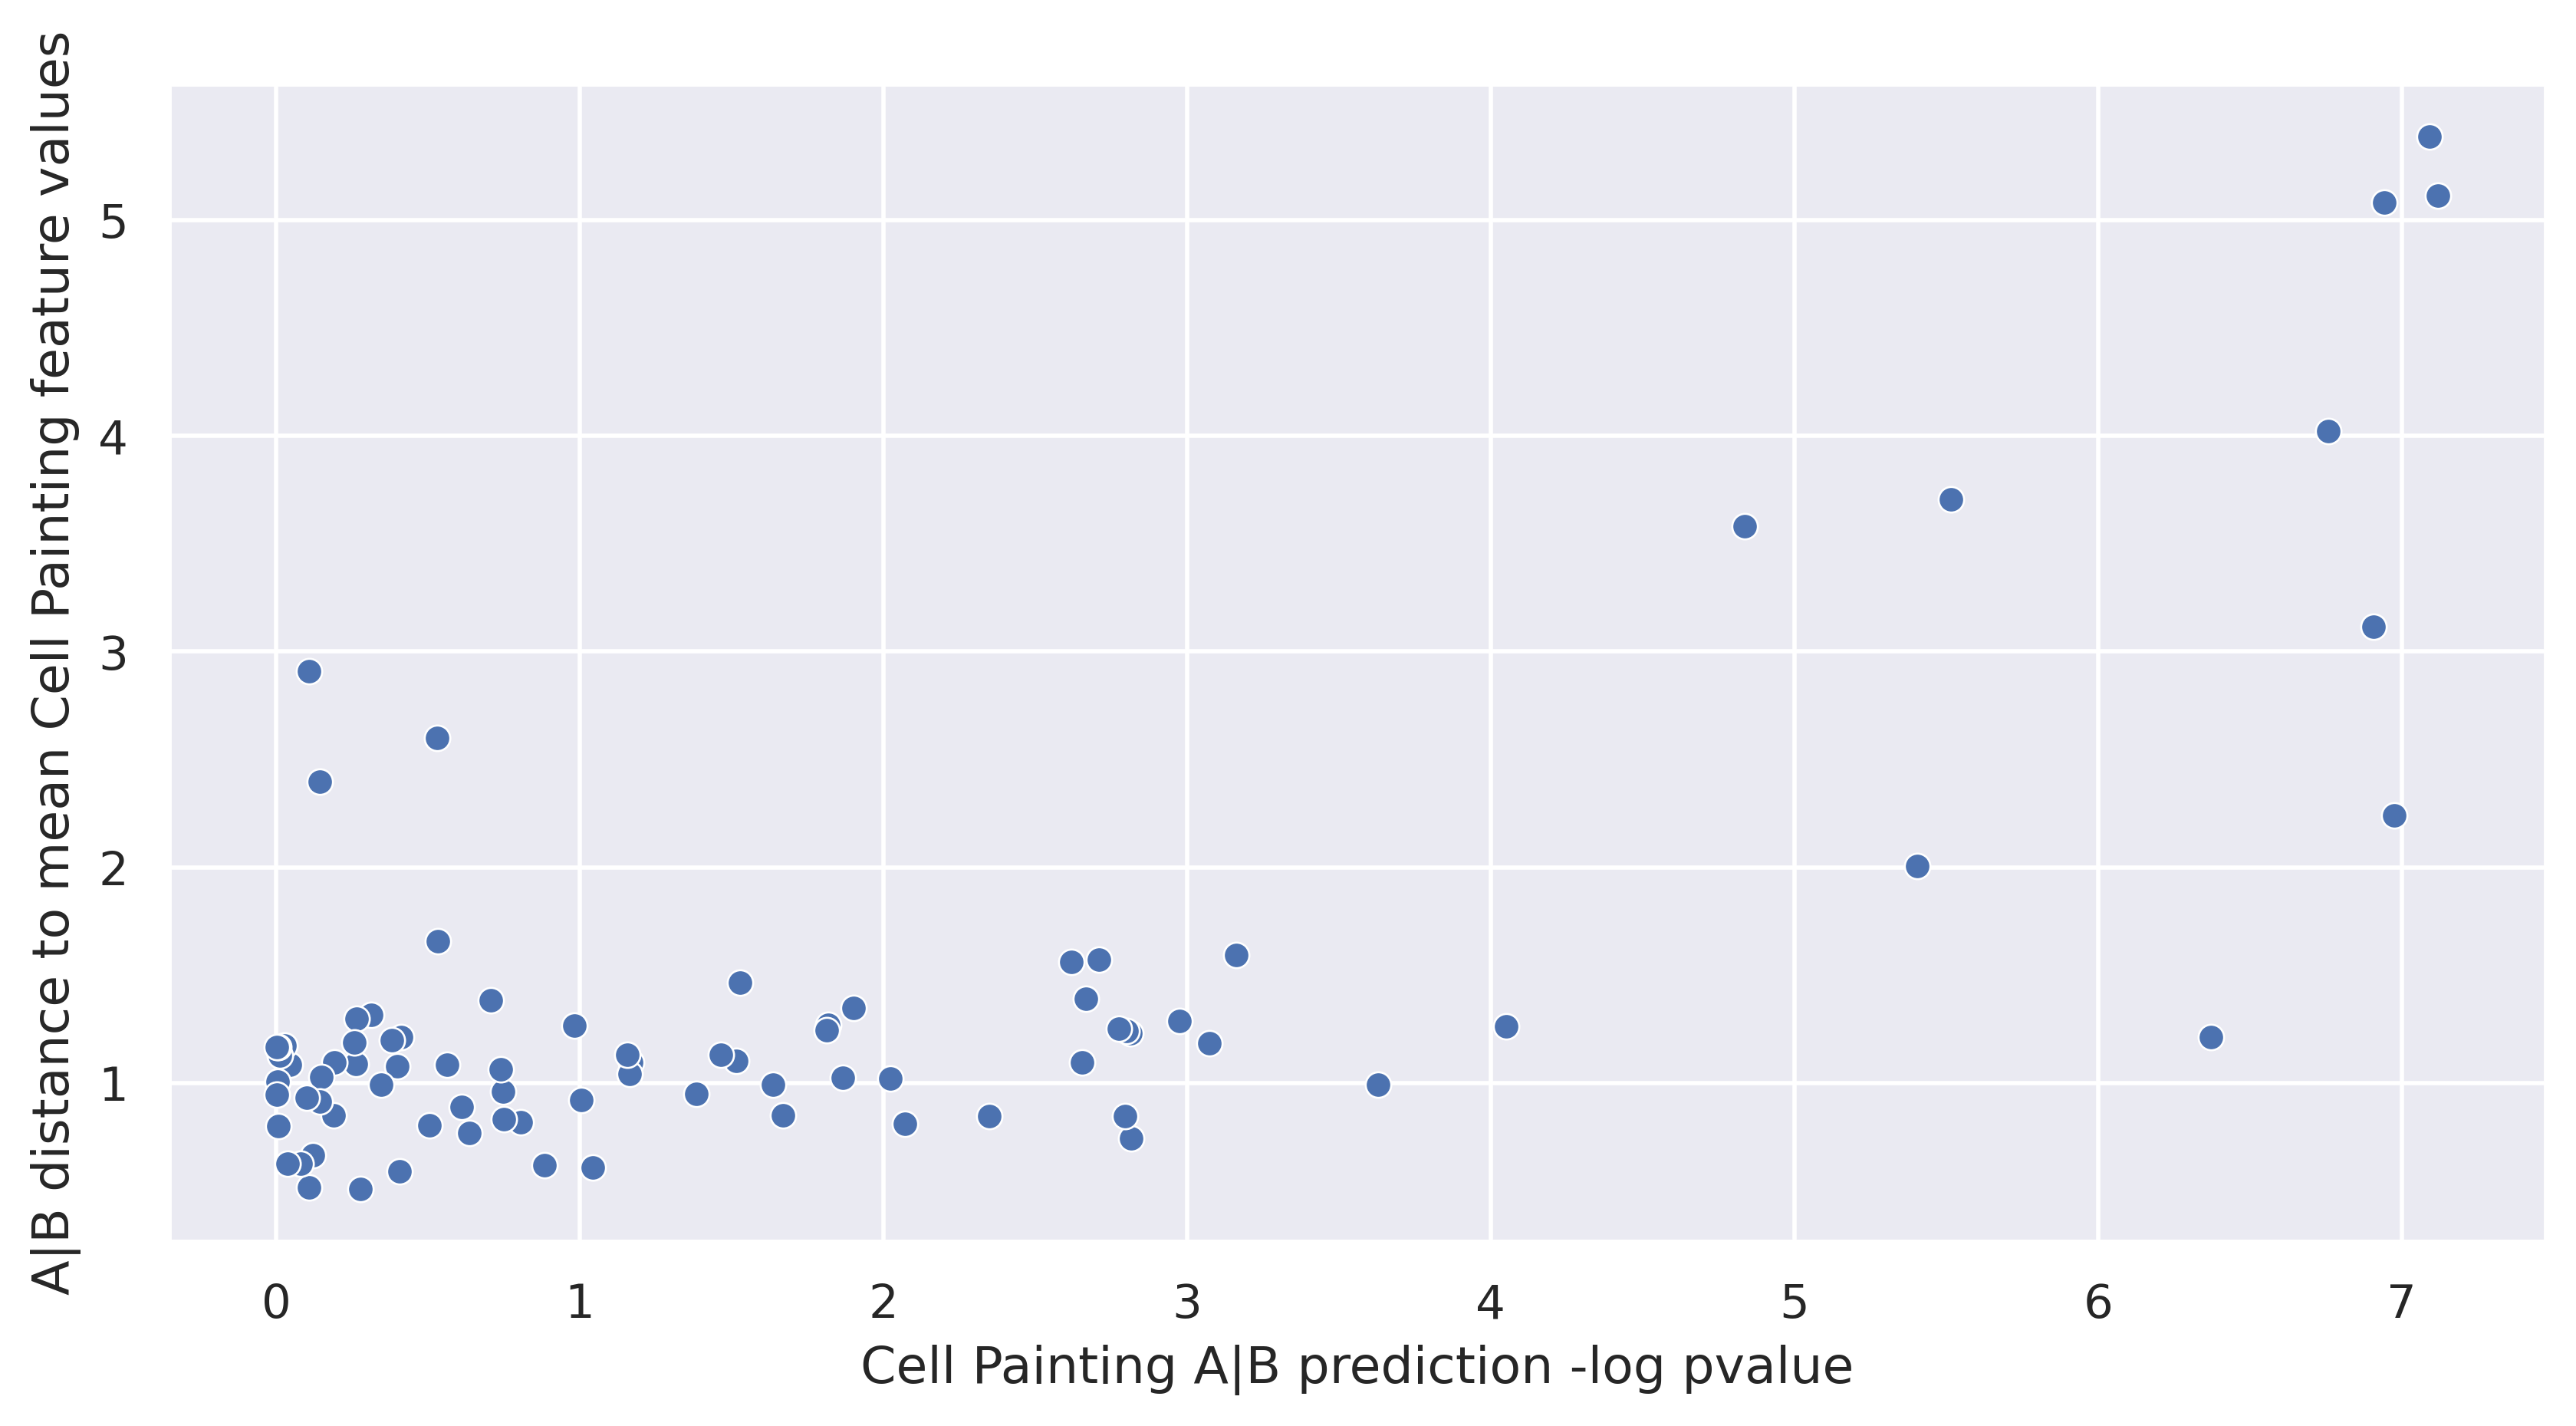

In [28]:
# per_moa_performance_df['vae pvalue'] = per_moa_performance_df['vae pvalue']/2
# per_moa_performance_df.loc[per_moa_performance_df['vae tstat'] > 0, 'vae pvalue'] = 1 - per_moa_performance_df['vae pvalue']
# per_moa_performance_df['vae pvalue']  = - np.log(per_moa_performance_df['vae pvalue'])


fig, ax = plt.subplots(figsize=(10, 5), dpi = 400)
sns.scatterplot(- np.log(scipy.stats.norm.sf(-(per_moa_performance_df['vae zscore']))), per_moa_performance_df['moa similarity'])
plt.xlabel("Cell Painting A|B prediction -log pvalue")
plt.ylabel("A|B distance to mean Cell Painting feature values")

In [22]:
L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
L2_df.to_csv('L2_general.tsv', sep = '\t')


# L2_df = pd.DataFrame(L2, columns = ['VAE Unshuffled'])
# L2_random_df = pd.DataFrame(L2_random, columns = ['VAE Shuffled'])
# L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
# L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
# L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df], ignore_index = True, axis = 1)
# L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled']
# L2_df.to_csv('L2_general.tsv', sep = '\t')

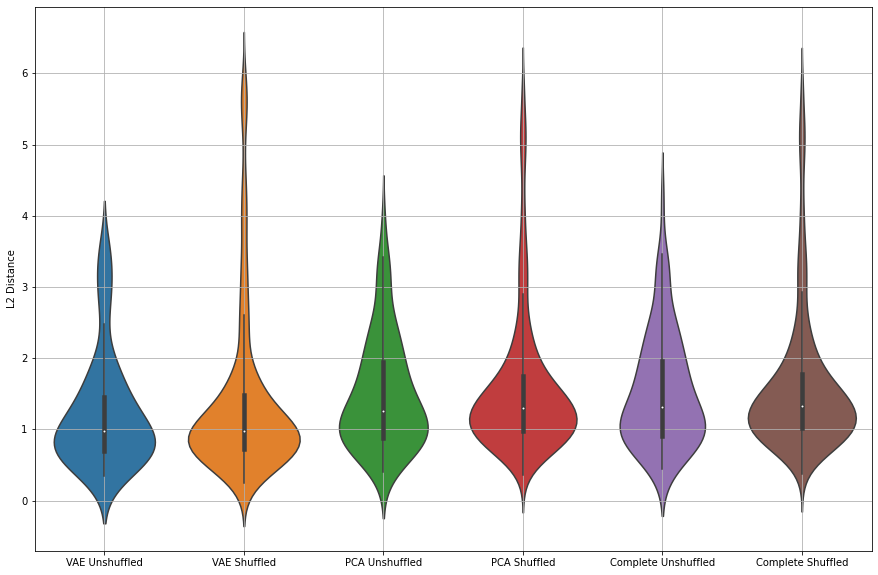

In [23]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [24]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,84.000000,840.000000,84.000000,840.000000,84.000000,840.000000
mean,1.246043,1.377747,1.501850,1.587793,1.547711,1.614556
std,0.804601,1.158267,0.782634,1.015541,0.795365,1.009502
min,0.345175,0.245087,0.398678,0.363183,0.441434,0.370953
25%,0.691806,0.730056,0.881700,0.980916,0.914178,1.018356
50%,0.978387,0.977925,1.264196,1.296486,1.309384,1.323627
75%,1.460773,1.478745,1.945271,1.750830,1.961255,1.782650
max,3.545097,5.978802,3.923328,5.835819,4.234526,5.834082


In [25]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#1.29
#1.51

Ttest_indResult(statistic=-1.0176398352457259, pvalue=0.3091161045865388)
Ttest_indResult(statistic=-0.7534341306626032, pvalue=0.4513814268248285)
Ttest_indResult(statistic=-0.5887733264746918, pvalue=0.5561575524408717)
